# <a id='toc1_'></a>[Figures](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Figures](#toc1_)    
  - [Functions used to simulate the magnetic field](#toc1_1_)    
  - [Accuracy results](#toc1_2_)    
  - [Weights analysis](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [17]:
import torch
import matplotlib.pyplot as plt 
import os
import datetime
from matplotlib.ticker import AutoMinorLocator
FOLDER = 'figures'
SIMULATION_FOLDER = 'simulations'
GRAPHS_ID = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
graph_folder = os.path.join(FOLDER, GRAPHS_ID)
os.makedirs(graph_folder, exist_ok=True)

## <a id='toc1_1_'></a>[Functions used to simulate the magnetic field](#toc0_)

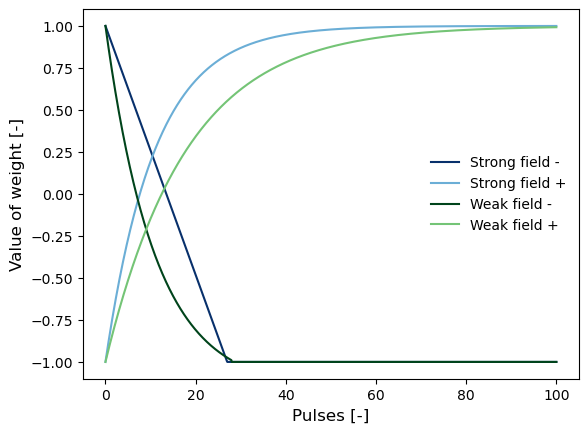

In [18]:
scale = 1
f_strong_minus = lambda x: ((-2*(1/27)*x + 2) * ((x < 27).float()) -1)*scale
f_strong_plus = lambda x: (1 - 2*torch.exp(-x/11))*scale 
f_weak_minus = lambda x: ((2.16*torch.exp(-x/11) - 0.16)* ((x < 28).float()) -1)*scale
f_weak_plus = lambda x: (1 - 2*torch.exp(-x/18))*scale
# plot all functions
fig, ax = plt.subplots()
x = torch.linspace(0, 100, 1000)
shades_blue = plt.get_cmap('Blues_r', 3)
shades_green = plt.get_cmap('Greens_r', 3)
ax.plot(x, f_strong_minus(x), label="Strong field -", color=shades_blue(0))
ax.plot(x, f_strong_plus(x), label="Strong field +", color=shades_blue(1))
ax.plot(x, f_weak_minus(x), label="Weak field -", color=shades_green(0))
ax.plot(x, f_weak_plus(x), label="Weak field +", color=shades_green(1))
ax.legend(loc='center right', fontsize=10, frameon=False)
ax.set_xlabel("Pulses [-]", fontsize=12)
ax.set_ylabel("Value of weight [-]", fontsize=12)
# export
name = "weight-evolution-" + GRAPHS_ID
fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')
fig.savefig(f"{graph_folder}/{name}.svg", bbox_inches='tight')

## <a id='toc1_2_'></a>[Accuracy results](#toc0_)

The data is loaded from the simulation path and the data is saved and displayed.

In [19]:
n_iterations = 5
paths = [
    f"20240708165908", # Strong field
    f"20240710101446" # Weak field
]
models = []
for path in paths:
    # first dim of the tensor is the iteration
    accuracies = []
    for it in range(n_iterations):
        current_folder = os.path.join(SIMULATION_FOLDER, path)
        accuracies.append(torch.load(os.path.join(current_folder, path+f"-{it}-accuracies.pth")))
    accuracies = torch.stack(accuracies)
    models.append(accuracies)
models = torch.stack(models)

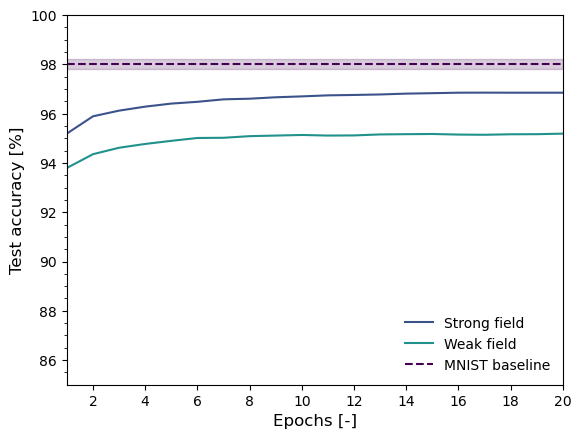

In [20]:
fig, ax = plt.subplots()
palette = plt.get_cmap('viridis', len(models)+3)
# Add mnist baseline 98% +- 0.2% for 512 hidden units
ax.hlines(98, 1, 20, color=palette(0), linestyle='--', label="MNIST baseline")
ax.fill_between([1, 20], 97.8, 98.2, alpha=0.2, color=palette(0))
# compare models
names = ["Strong field", "Weak field"] 
for i, model in enumerate(models):
    mean = torch.mean(model, dim=0)
    std = torch.std(model, dim=0)
    # add one element to the beginning of the tensor
    mean = torch.cat((torch.tensor([0.0]), mean))
    std = torch.cat((torch.tensor([0.0]), std))
    ax.plot(mean*100, label=f"{names[i]}", color=palette(i+1))
    ax.fill_between(mean - std, mean + std, alpha=0.2, color=palette(i+1))

ax.set_xlabel("Epochs [-]", fontsize=12)
ax.set_ylabel("Test accuracy [%]", fontsize=12)
ax.legend(loc='lower right', fontsize=10, frameon=False)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylim([85, 100])
ax.set_xticks(range(0, 21,2))
ax.set_xlim([1, 20])
plt.show()
# save as pdf and svg
name = "weak-vs-strong-" + GRAPHS_ID
fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')
fig.savefig(f"{graph_folder}/{name}.svg", bbox_inches='tight')
    

## <a id='toc1_3_'></a>[Weights analysis](#toc0_)

In [30]:
paths = [
    f"20240708165908", # Strong field
    f"20240710101446" # Weak field
]
models = []
for path in paths:
    # first dim of the tensor is the iteration
    accuracies = []
    current_folder = os.path.join(SIMULATION_FOLDER, path)
    accuracies.append(torch.load(os.path.join(current_folder, path+f"-0.pth")))
    models.append(accuracies)

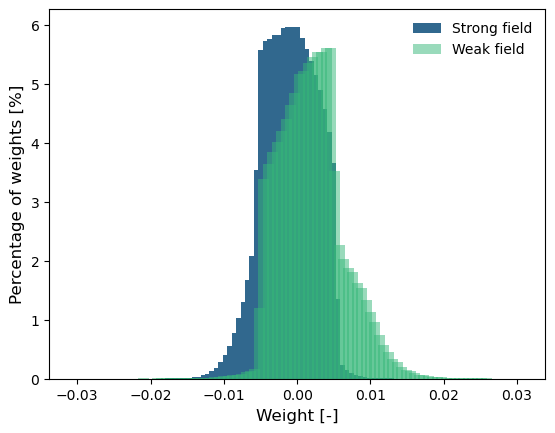

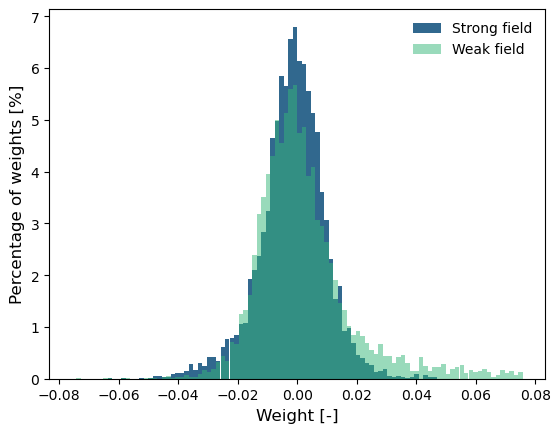

In [84]:
minimum = [-0.03, -0.075]
maximum = [0.03, 0.075]
# weights keys (layers.1.weght)
keys = ["layers.1.weight", "layers.4.weight"]
for k, key in enumerate(keys):
    fig, ax = plt.subplots()
    palette = plt.get_cmap('viridis', len(models)+2)
    # compare models
    names = ["Strong field", "Weak field"]
    for i, model in enumerate(models):
        weights = model[0][key].flatten()
        hist = torch.histc(weights, bins=100, min=minimum[k], max=maximum[k]).to('cpu')
        # plot in % of the total weights
        ax.bar(torch.linspace(minimum[k], maximum[k], 100), height=hist/len(weights)*100, width=0.0015, label=f"{names[i]}", color=palette(i+1), alpha=0.5 if i==1 else 1)
    ax.set_xlabel("Weight [-]", fontsize=12)
    ax.set_ylabel("Percentage of weights [%]", fontsize=12)
    ax.legend(loc='upper right', fontsize=10, frameon=False)
    plt.show()